In [1]:
import os
import json
from datetime import datetime
from json import JSONDecodeError
import pandas as pd
import numpy as np

def generate_dataset(home_dir,dataset_name):
    
    """generate_dataset: This function assumes the data is 
    distributed in folders from a parent directory. 
    Each folder contains comma-separated files where each 
    row is defined with a JSON notation.
    Arguments:
        home_dir [string] -- parent directory
        dataset_name [ [string] ] -- Target folder name
    Returns:
        {data_df} -- Pandas dataframe with all the information joined,
                    cleaned and ready to use.
    """
    home_dir = home_dir +"/" + dataset_name
    pi_dirs = os.listdir(home_dir)
    data_list = []
    columns = None
    
    for pi_dir in pi_dirs:
        if 'pi' not in pi_dir:
            continue
        curr_dir = os.path.join(home_dir, pi_dir)
        data_file = os.path.join(curr_dir, os.listdir(curr_dir)[0])
        with open(data_file, 'r') as f:
            line = f.readline().strip().replace("'", '"')
            while line != '':
                try:
                    input_json = json.loads(line)
                    sensor_datetime = datetime.fromtimestamp(input_json['time'])
                    input_json['time'] = sensor_datetime
                    input_json['pi'] = pi_dir
                    data_list.append(list(input_json.values()))
                    if columns is None:
                        columns = list(input_json.keys())
                except JSONDecodeError as je:
                    pass
                line = f.readline().strip().replace("'", '"')
    
    data_df = pd.DataFrame(data_list, columns=columns)
    
    #@TODO: Include an argument to decide the target columns we want in the final dataset.
    del data_df['experiment']
    del data_df['device']
    del data_df['time']
    del data_df['pi']
    data_df = data_df.replace(to_replace=' None', value=np.nan).dropna()
    return data_df

# Keys
Xtrain="xtrain"
Xtest="xtest"
Ytrain="ytrain"
Ytest="ytest"

def split_data(x,y, test_size=0.2):
    dd={}
    from sklearn.model_selection import train_test_split
    dd[Xtrain],dd[Xtest],dd[Ytrain],dd[Ytest]=train_test_split(x,y,test_size=test_size)
    return dd

def train_model(x_train, y_train, x_test, y_test,kernel='rbf', C=100, gamma=10):
    
    # svr is a support vector regression model
    #0.0001 < gamma < 10
    #0.1 < c < 100
    from sklearn.svm import SVR
    svr = SVR(kernel=kernel, C=C, gamma=gamma)
    model = svr.fit(x_train,y_train)
    score = model.score(x_test,y_test)

        
    return model,score

def test_model(model,x_test,y_test):
    
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    from numpy import sqrt
    
    predictions = model.predict(x_test)
    y_predicted = pd.DataFrame(predictions, columns=['predicted'])
    
    mse = mean_squared_error(y_test, y_predicted)
    #mae = mean_absolute_error(y_test, y_predicted)
    rmse = sqrt(mse)
    
    return mse,rmse,y_predicted

def plot_model(x_test,y_test,y_predicted,name='', x_name='x',y_name='y'):

    import matplotlib.pyplot as plt
    
    plt.scatter(x_test, y_test, c='tab:green', label='original')
    plt.plot(x_test, y_predicted, c='tab:red', label='predicted')
    
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title('Support Vector Regression ' +str(name))
    plt.legend()
    plt.show()

# Needed for generating classification, regression and clustering datasets
import sklearn.datasets as dt
from sklearn.cluster import KMeans

def generate_data(dataset,n_clusters,x_name,y_name):
    from pandas import DataFrame
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans

    kmeans = KMeans(n_clusters=n_clusters).fit(dataset)
    centroids = kmeans.cluster_centers_
    
    # We build a dictionary for each cluster with the corresponding dataframe using the position obtained in Kmeans
    # We split the x,y into train and test sets
    
    datasets = {}
    
    samples = {kmeans.cluster_centers_[i, 0]: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}

    nodes_index=0
    for k in samples.keys():
        datasets["n"+str(nodes_index)]={}
        d = dataset.iloc[samples[k], :]
        
        X=d.copy().drop(columns=[yvar])
        y=d[yvar].copy()
        
        datasets["n"+str(nodes_index)]["full"] = d
        datasets["n"+str(nodes_index)]["split"] = split_data(X,y,test_size=0.2)
        nodes_index = nodes_index +1
        
    return centroids, datasets, kmeans
    

def plot_nodes(dataset,centroids,x_name,y_name,kmeans):
    import matplotlib.pyplot as plt
    labels = ['n{0}'.format(i) for i in range(len(centroids))]
    plt_data = plt.scatter(dataset[x_name], dataset[y_name], c= kmeans.labels_.astype(float))
    plt.colorbar()
    plt.scatter(centroids[:, 1], centroids[:, 0], marker='x')
    plt.title('K-means clustering')
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    labels = ['n{0}'.format(i) for i in range(K)]
    for i in range (K):
        xy=(centroids[i, 1],centroids[i, 0])
        plt.annotate(labels[i],xy, horizontalalignment='right', verticalalignment='top',
              bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.95', 
                                color='b'))

    plt.show()    

## Evaluate the impact of C and gamma

Support Vector Machine (SVM) is a widely-used supervised machine learning algorithm. It is mostly used in classification tasks but is suitable for regression tasks. 

Most of the machine learning and deep learning algorithms have some parameters that can be adjusted which are called hyperparameters. We need to set hyperparameters before we train the models. Hyperparameters are very critical in building robust and accurate models. They help us find the balance between bias and variance and thus, prevent the model from overfitting or underfitting. 

We emphasized the importance of hyperparameters. Let’s start our discussion on C and gamma. SVM creates a decision boundary that makes the distinction between two or more classes. How to draw or determine the decision boundary is the most critical part of SVM algorithms. When the data points in different classes are linearly separable, it is an easy task to draw a decision boundary.

C parameter adds a penalty for each misclassified data point. If c is small, the penalty for misclassified points is low so a decision boundary with a large margin is chosen at the expense of a greater number of misclassifications. If c is large, SVM tries to minimize the number of misclassified examples due to high penalty which results in a decision boundary with a smaller margin. 

For a linear kernel, we just need to optimize the c parameter. However, if we want to use an RBF kernel, both c and gamma parameters need to be optimized simultaneously. If gamma is large, the effect of c becomes negligible. If gamma is small, c affects the model just like how it affects a linear model. Typical values for c and gamma are as follows.

However, specific optimal values may exist depending on the application:

$$
0.0001 < gamma < 10
\\
0.1 < c < 100
$$


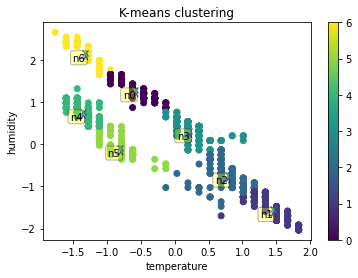

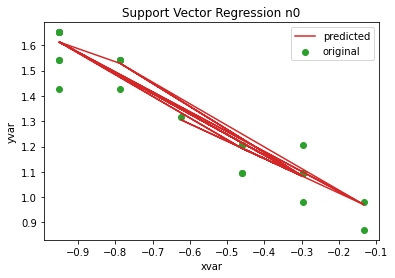

Accuracy of model: SVR(C=1, gamma=10) === 92.88% (nº of correct predictions)"
Performance of model: n0 === 0.00 (MSE)
How far are the data points from the regression line: n0 === 0.06 (RMSE)


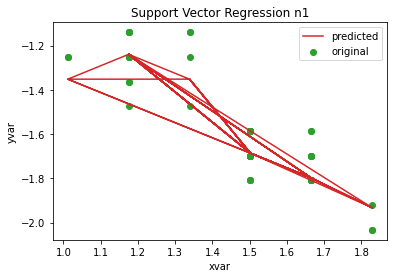

Accuracy of model: SVR(C=100, gamma=10) === 82.12% (nº of correct predictions)"
Performance of model: n1 === 0.01 (MSE)
How far are the data points from the regression line: n1 === 0.10 (RMSE)


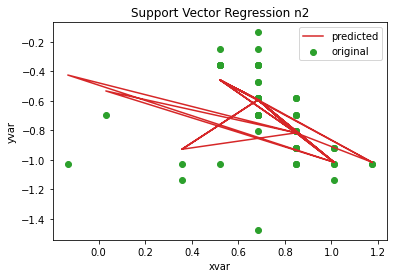

Accuracy of model: SVR(C=10, gamma=10) === 40.19% (nº of correct predictions)"
Performance of model: n2 === 0.05 (MSE)
How far are the data points from the regression line: n2 === 0.22 (RMSE)


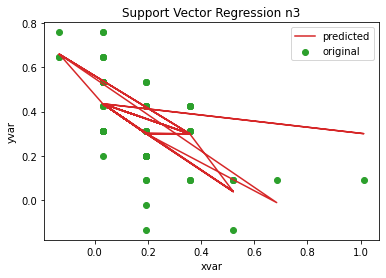

Accuracy of model: SVR(C=1, gamma=10) === 42.91% (nº of correct predictions)"
Performance of model: n3 === 0.02 (MSE)
How far are the data points from the regression line: n3 === 0.15 (RMSE)


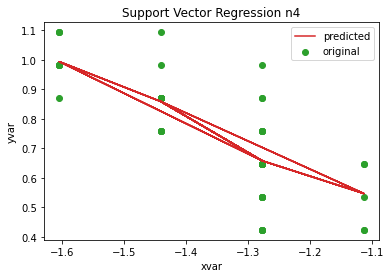

Accuracy of model: SVR(C=10, gamma=10) === 62.39% (nº of correct predictions)"
Performance of model: n4 === 0.01 (MSE)
How far are the data points from the regression line: n4 === 0.12 (RMSE)


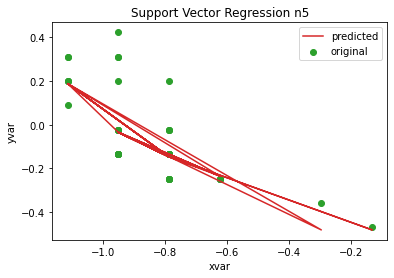

Accuracy of model: SVR(C=1, gamma=10) === 53.10% (nº of correct predictions)"
Performance of model: n5 === 0.02 (MSE)
How far are the data points from the regression line: n5 === 0.14 (RMSE)


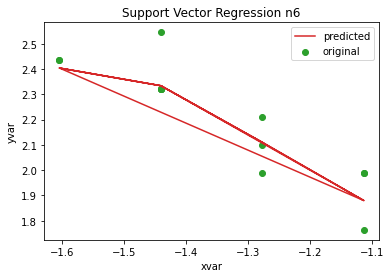

Accuracy of model: SVR(C=0.1, gamma=10) === 82.54% (nº of correct predictions)"
Performance of model: n6 === 0.01 (MSE)
How far are the data points from the regression line: n6 === 0.09 (RMSE)


In [4]:
home_dir = '../datasets'
dataset = 'GNFUV-USV-Dataset'

# This variable contains the name of the columns and represents the variables we want to study
yvar='humidity'
xvar='temperature'
target_columns=[xvar,yvar]

# D represents the global dataset (all the points).
D = generate_dataset(home_dir,dataset)

from sklearn.preprocessing import StandardScaler

standaritzation = StandardScaler()
standaritzation.fit(D[target_columns])
scaled=standaritzation.transform(D[target_columns])
D_Scaled = D.copy()
D_Scaled[target_columns] = scaled

K=7
centroids,D_,kmeans = generate_data(D_Scaled,K,xvar,yvar)
plot_nodes(D_Scaled,centroids,xvar,yvar,kmeans)

index_model=0
models={}

gammas=[0.0001,0.001,0.01,0.1,1,10]
cs=[0.1,1,10,100]

def update_best(c,model,score,py,g,rmse,mse):
    d={}
    d['c']=c
    d['model']=model
    d['score']=score
    d['prediction']=py
    d['gamma']=g
    d['rmse']=rmse
    d['mse']=mse
    return d


best={}
for n in D_.keys():
    best[n]={}
    di=D_[n]['split']
    for g in gammas:
        for c in cs:
            model,score = train_model(di[Xtrain],di[Ytrain],di[Xtest],di[Ytest],C=c,gamma=g)
            mse,rmse,py=test_model(model,di[Xtest],di[Ytest])

            if best[n] == {}:
                best[n]= update_best(c,model,score,py,g,rmse,mse)
            elif rmse < best[n]['rmse']:
                best[n] = update_best(c,model,score,py,g,rmse,mse)
       
    plot_model(di[Xtest],di[Ytest],best[n]["prediction"],n,"xvar","yvar")
    print('Accuracy of model: {} === {:.2f}% (nº of correct predictions)"'.format(best[n]["model"], best[n]["score"]*100))
    print('Performance of model: {} === {:.2f} (MSE)'.format(n, best[n]["mse"]))
    print('How far are the data points from the regression line: {} === {:.2f} (RMSE)'.format(n, best[n]["rmse"]))
                      
         


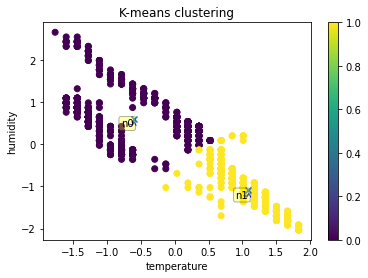

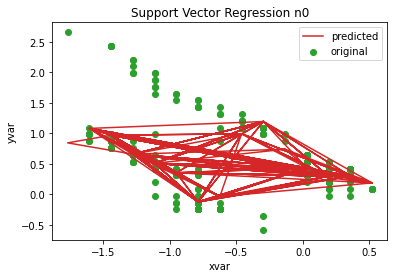

Accuracy of model: SVR(C=1, gamma=10) === 14.55% (nº of correct predictions)"
Performance of model: n0 === 0.34 (MSE)
How far are the data points from the regression line: n0 === 0.58 (RMSE)


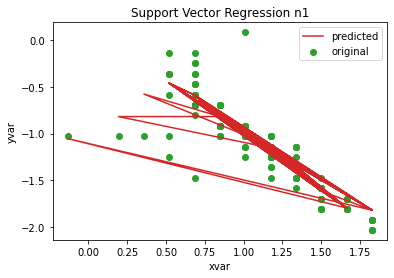

Accuracy of model: SVR(C=0.1, gamma=10) === 80.70% (nº of correct predictions)"
Performance of model: n1 === 0.05 (MSE)
How far are the data points from the regression line: n1 === 0.21 (RMSE)


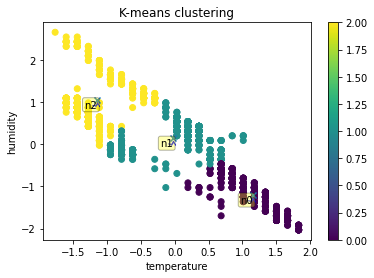

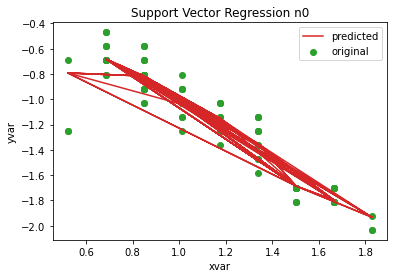

Accuracy of model: SVR(C=1, gamma=10) === 91.14% (nº of correct predictions)"
Performance of model: n0 === 0.02 (MSE)
How far are the data points from the regression line: n0 === 0.13 (RMSE)


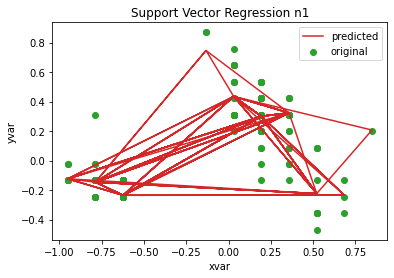

Accuracy of model: SVR(C=1, gamma=10) === 74.07% (nº of correct predictions)"
Performance of model: n1 === 0.02 (MSE)
How far are the data points from the regression line: n1 === 0.15 (RMSE)


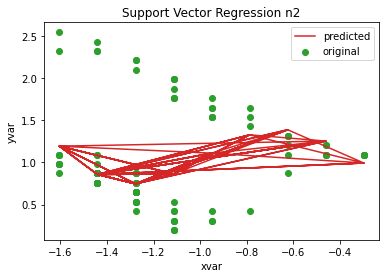

Accuracy of model: SVR(C=10, gamma=1) === -0.23% (nº of correct predictions)"
Performance of model: n2 === 0.31 (MSE)
How far are the data points from the regression line: n2 === 0.56 (RMSE)


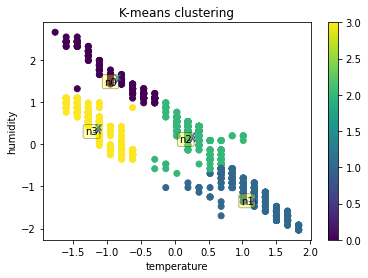

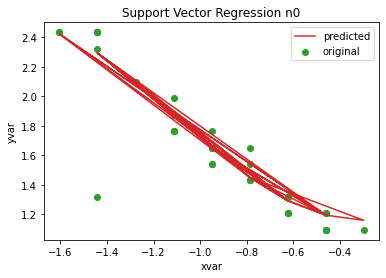

Accuracy of model: SVR(C=0.1, gamma=1) === 84.07% (nº of correct predictions)"
Performance of model: n0 === 0.03 (MSE)
How far are the data points from the regression line: n0 === 0.18 (RMSE)


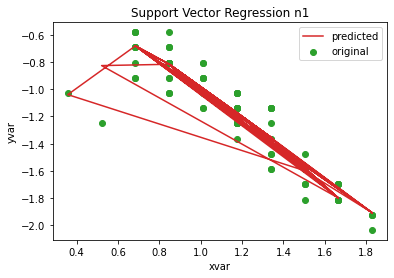

Accuracy of model: SVR(C=0.1, gamma=10) === 90.22% (nº of correct predictions)"
Performance of model: n1 === 0.01 (MSE)
How far are the data points from the regression line: n1 === 0.12 (RMSE)


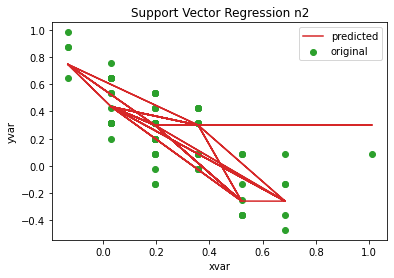

Accuracy of model: SVR(C=1, gamma=10) === 61.02% (nº of correct predictions)"
Performance of model: n2 === 0.03 (MSE)
How far are the data points from the regression line: n2 === 0.18 (RMSE)


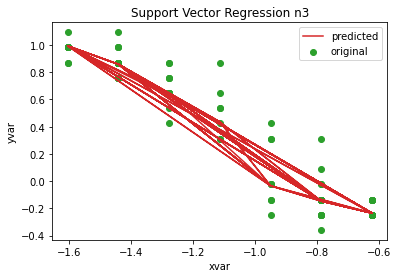

Accuracy of model: SVR(C=100, gamma=10) === 92.71% (nº of correct predictions)"
Performance of model: n3 === 0.02 (MSE)
How far are the data points from the regression line: n3 === 0.13 (RMSE)


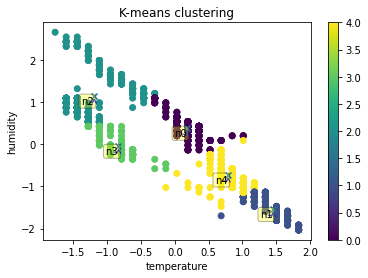

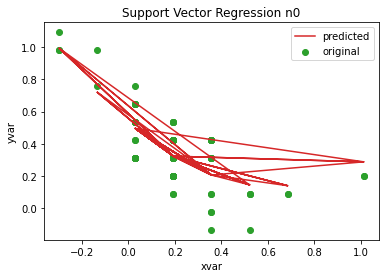

Accuracy of model: SVR(C=10, gamma=0.1) === 61.20% (nº of correct predictions)"
Performance of model: n0 === 0.02 (MSE)
How far are the data points from the regression line: n0 === 0.15 (RMSE)


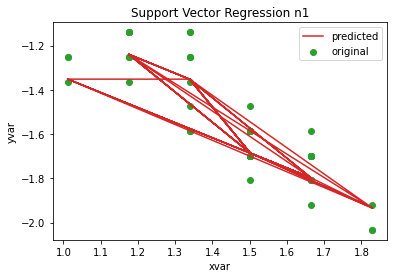

Accuracy of model: SVR(C=10, gamma=10) === 79.98% (nº of correct predictions)"
Performance of model: n1 === 0.01 (MSE)
How far are the data points from the regression line: n1 === 0.11 (RMSE)


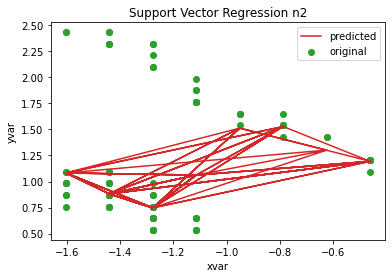

Accuracy of model: SVR(C=0.1, gamma=10) === -11.53% (nº of correct predictions)"
Performance of model: n2 === 0.37 (MSE)
How far are the data points from the regression line: n2 === 0.61 (RMSE)


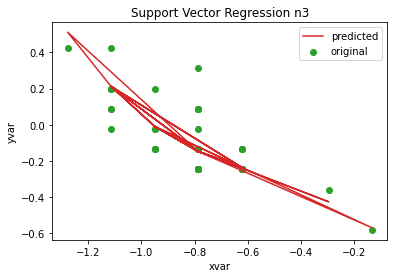

Accuracy of model: SVR(C=10, gamma=1) === 61.64% (nº of correct predictions)"
Performance of model: n3 === 0.02 (MSE)
How far are the data points from the regression line: n3 === 0.13 (RMSE)


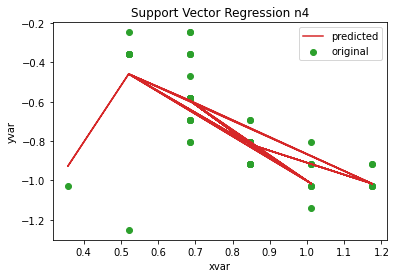

Accuracy of model: SVR(C=10, gamma=10) === 60.45% (nº of correct predictions)"
Performance of model: n4 === 0.02 (MSE)
How far are the data points from the regression line: n4 === 0.16 (RMSE)


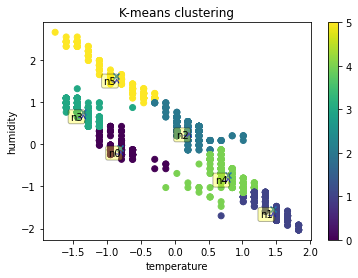

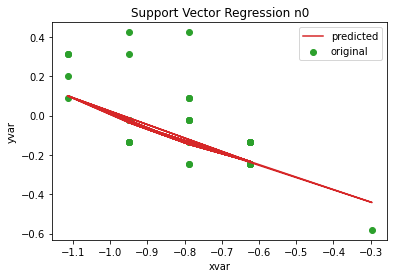

Accuracy of model: SVR(C=100, gamma=10) === 34.28% (nº of correct predictions)"
Performance of model: n0 === 0.03 (MSE)
How far are the data points from the regression line: n0 === 0.17 (RMSE)


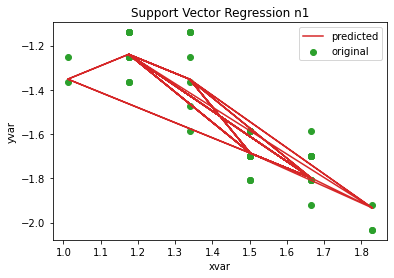

Accuracy of model: SVR(C=10, gamma=10) === 84.24% (nº of correct predictions)"
Performance of model: n1 === 0.01 (MSE)
How far are the data points from the regression line: n1 === 0.11 (RMSE)


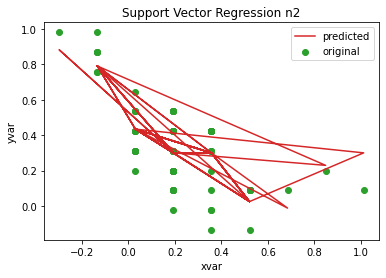

Accuracy of model: SVR(C=1, gamma=10) === 60.19% (nº of correct predictions)"
Performance of model: n2 === 0.02 (MSE)
How far are the data points from the regression line: n2 === 0.15 (RMSE)


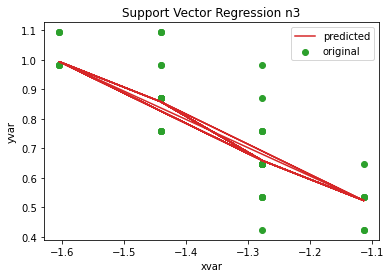

Accuracy of model: SVR(C=100, gamma=1) === 69.71% (nº of correct predictions)"
Performance of model: n3 === 0.01 (MSE)
How far are the data points from the regression line: n3 === 0.10 (RMSE)


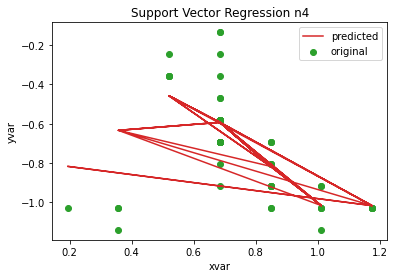

Accuracy of model: SVR(C=10, gamma=10) === 54.51% (nº of correct predictions)"
Performance of model: n4 === 0.03 (MSE)
How far are the data points from the regression line: n4 === 0.17 (RMSE)


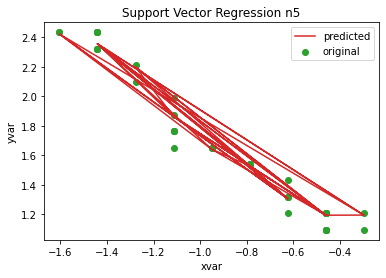

Accuracy of model: SVR(C=1, gamma=10) === 97.74% (nº of correct predictions)"
Performance of model: n5 === 0.01 (MSE)
How far are the data points from the regression line: n5 === 0.07 (RMSE)


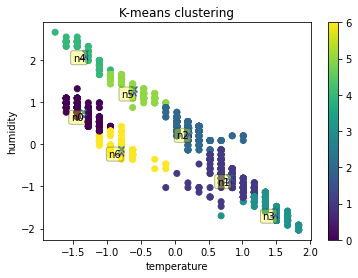

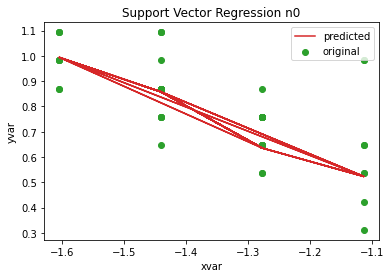

Accuracy of model: SVR(C=10, gamma=10) === 39.36% (nº of correct predictions)"
Performance of model: n0 === 0.02 (MSE)
How far are the data points from the regression line: n0 === 0.13 (RMSE)


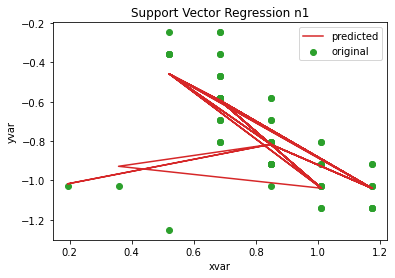

Accuracy of model: SVR(C=10, gamma=10) === 61.59% (nº of correct predictions)"
Performance of model: n1 === 0.03 (MSE)
How far are the data points from the regression line: n1 === 0.17 (RMSE)


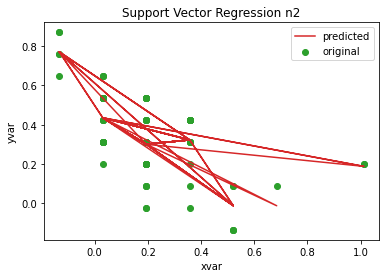

Accuracy of model: SVR(C=100, gamma=10) === 57.01% (nº of correct predictions)"
Performance of model: n2 === 0.02 (MSE)
How far are the data points from the regression line: n2 === 0.14 (RMSE)


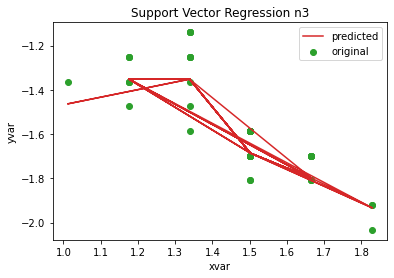

Accuracy of model: SVR(C=100, gamma=10) === 79.15% (nº of correct predictions)"
Performance of model: n3 === 0.01 (MSE)
How far are the data points from the regression line: n3 === 0.10 (RMSE)


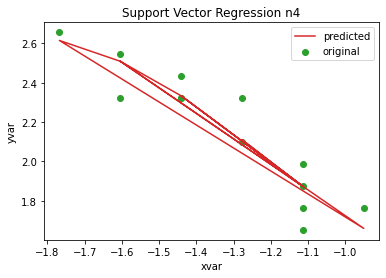

Accuracy of model: SVR(C=1, gamma=1) === 85.89% (nº of correct predictions)"
Performance of model: n4 === 0.01 (MSE)
How far are the data points from the regression line: n4 === 0.12 (RMSE)


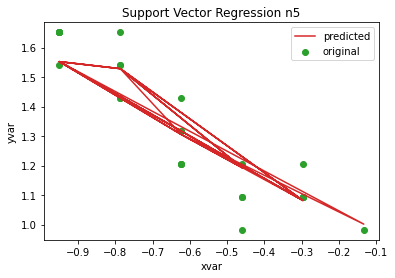

Accuracy of model: SVR(C=10, gamma=10) === 85.30% (nº of correct predictions)"
Performance of model: n5 === 0.01 (MSE)
How far are the data points from the regression line: n5 === 0.09 (RMSE)


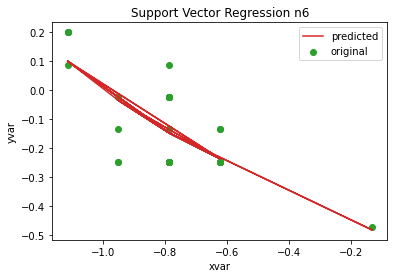

Accuracy of model: SVR(C=1, gamma=10) === 55.15% (nº of correct predictions)"
Performance of model: n6 === 0.01 (MSE)
How far are the data points from the regression line: n6 === 0.10 (RMSE)


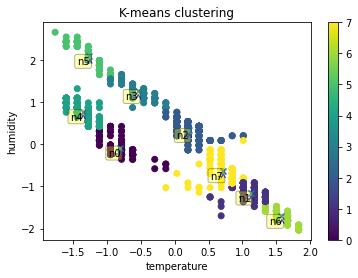

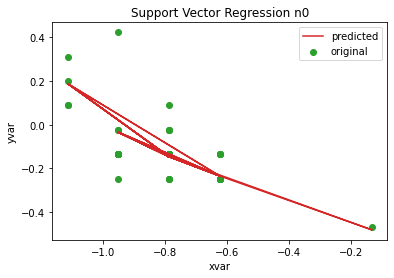

Accuracy of model: SVR(C=1, gamma=10) === 48.79% (nº of correct predictions)"
Performance of model: n0 === 0.01 (MSE)
How far are the data points from the regression line: n0 === 0.11 (RMSE)


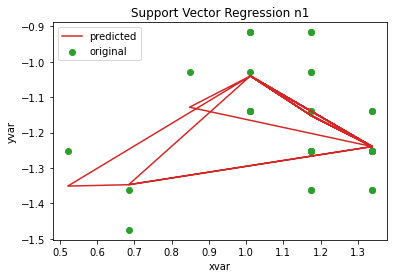

Accuracy of model: SVR(C=1, gamma=10) === 40.37% (nº of correct predictions)"
Performance of model: n1 === 0.01 (MSE)
How far are the data points from the regression line: n1 === 0.12 (RMSE)


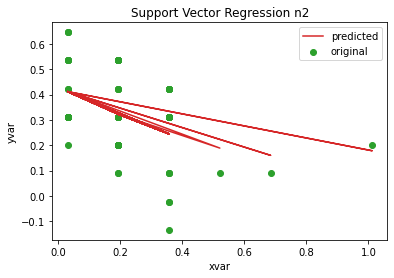

Accuracy of model: SVR(C=0.1, gamma=1) === 19.41% (nº of correct predictions)"
Performance of model: n2 === 0.02 (MSE)
How far are the data points from the regression line: n2 === 0.15 (RMSE)


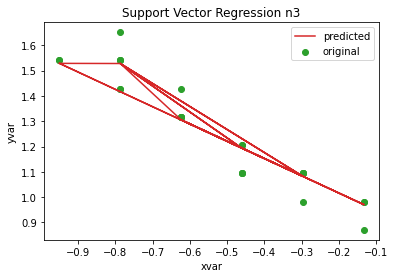

Accuracy of model: SVR(C=10, gamma=10) === 91.67% (nº of correct predictions)"
Performance of model: n3 === 0.00 (MSE)
How far are the data points from the regression line: n3 === 0.06 (RMSE)


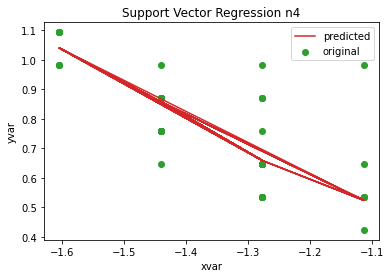

Accuracy of model: SVR(C=10, gamma=1) === 56.33% (nº of correct predictions)"
Performance of model: n4 === 0.01 (MSE)
How far are the data points from the regression line: n4 === 0.11 (RMSE)


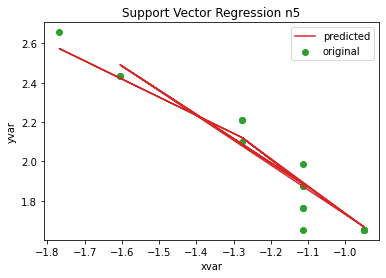

Accuracy of model: SVR(C=1, gamma=1) === 92.29% (nº of correct predictions)"
Performance of model: n5 === 0.01 (MSE)
How far are the data points from the regression line: n5 === 0.09 (RMSE)


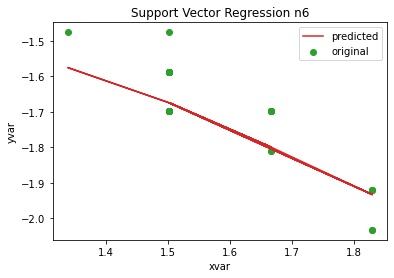

Accuracy of model: SVR(C=1, gamma=1) === 67.13% (nº of correct predictions)"
Performance of model: n6 === 0.01 (MSE)
How far are the data points from the regression line: n6 === 0.08 (RMSE)


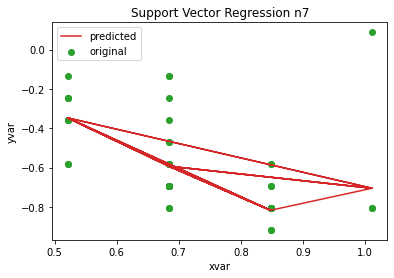

Accuracy of model: SVR(C=100, gamma=10) === 34.03% (nº of correct predictions)"
Performance of model: n7 === 0.04 (MSE)
How far are the data points from the regression line: n7 === 0.20 (RMSE)


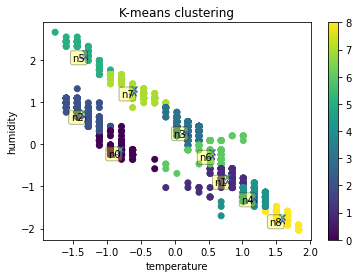

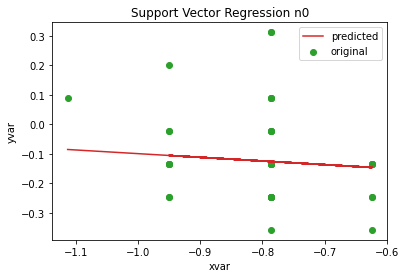

Accuracy of model: SVR(C=100, gamma=0.0001) === 1.95% (nº of correct predictions)"
Performance of model: n0 === 0.03 (MSE)
How far are the data points from the regression line: n0 === 0.16 (RMSE)


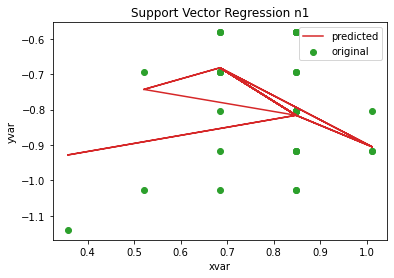

Accuracy of model: SVR(C=0.1, gamma=10) === 6.54% (nº of correct predictions)"
Performance of model: n1 === 0.02 (MSE)
How far are the data points from the regression line: n1 === 0.15 (RMSE)


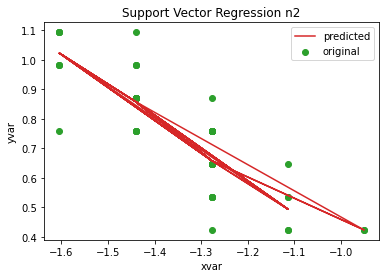

Accuracy of model: SVR(C=10, gamma=1) === 72.89% (nº of correct predictions)"
Performance of model: n2 === 0.01 (MSE)
How far are the data points from the regression line: n2 === 0.10 (RMSE)


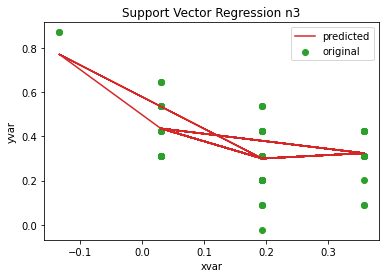

Accuracy of model: SVR(C=100, gamma=1) === 43.22% (nº of correct predictions)"
Performance of model: n3 === 0.02 (MSE)
How far are the data points from the regression line: n3 === 0.13 (RMSE)


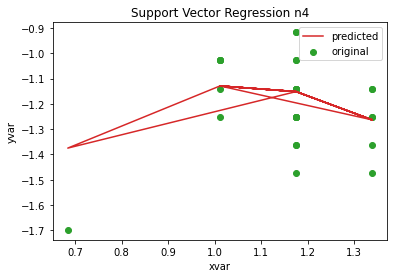

Accuracy of model: SVR(C=100, gamma=1) === 27.09% (nº of correct predictions)"
Performance of model: n4 === 0.02 (MSE)
How far are the data points from the regression line: n4 === 0.15 (RMSE)


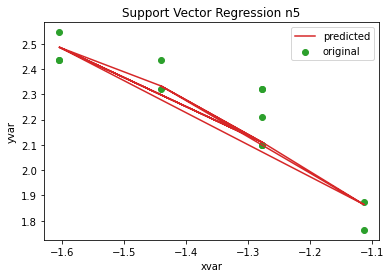

Accuracy of model: SVR(C=100, gamma=1) === 79.89% (nº of correct predictions)"
Performance of model: n5 === 0.01 (MSE)
How far are the data points from the regression line: n5 === 0.10 (RMSE)


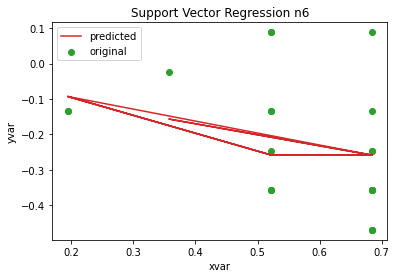

Accuracy of model: SVR(C=100, gamma=1) === 7.25% (nº of correct predictions)"
Performance of model: n6 === 0.03 (MSE)
How far are the data points from the regression line: n6 === 0.17 (RMSE)


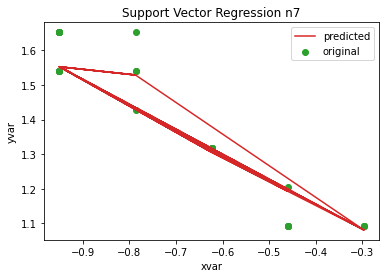

Accuracy of model: SVR(C=100, gamma=10) === 90.30% (nº of correct predictions)"
Performance of model: n7 === 0.00 (MSE)
How far are the data points from the regression line: n7 === 0.07 (RMSE)


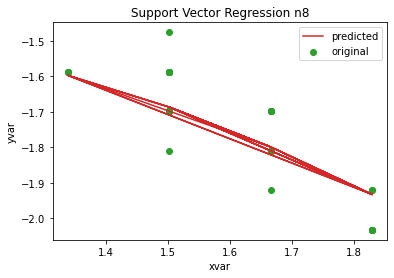

Accuracy of model: SVR(C=100, gamma=0.1) === 70.95% (nº of correct predictions)"
Performance of model: n8 === 0.01 (MSE)
How far are the data points from the regression line: n8 === 0.08 (RMSE)


In [8]:
home_dir = '../datasets'
dataset = 'GNFUV-USV-Dataset'

# This variable contains the name of the columns and represents the variables we want to study
yvar='humidity'
xvar='temperature'
target_columns=[xvar,yvar]

# D represents the global dataset (all the points).
D = generate_dataset(home_dir,dataset)

from sklearn.preprocessing import StandardScaler

standaritzation = StandardScaler()
standaritzation.fit(D[target_columns])
scaled=standaritzation.transform(D[target_columns])
D_Scaled = D.copy()
D_Scaled[target_columns] = scaled

index_model=0
models={}

gammas=[0.0001,0.001,0.01,0.1,1,10]
cs=[0.1,1,10,100]

def update_best(c,model,score,py,g,rmse,mse):
    d={}
    d['c']=c
    d['model']=model
    d['score']=score
    d['prediction']=py
    d['gamma']=g
    d['rmse']=rmse
    d['mse']=mse
    return d


ks = [x for x in range(2,10)]

for K in ks:

    centroids,D_,kmeans = generate_data(D_Scaled,K,xvar,yvar)
    plot_nodes(D_Scaled,centroids,xvar,yvar,kmeans)

    best={}
    for n in D_.keys():
        best[n]={}
        di=D_[n]['split']
        for g in gammas:
            for c in cs:
                model,score = train_model(di[Xtrain],di[Ytrain],di[Xtest],di[Ytest],C=c,gamma=g)
                mse,rmse,py=test_model(model,di[Xtest],di[Ytest])

                if best[n] == {}:
                    best[n]= update_best(c,model,score,py,g,rmse,mse)
                elif rmse < best[n]['rmse']:
                    best[n] = update_best(c,model,score,py,g,rmse,mse)

        plot_model(di[Xtest],di[Ytest],best[n]["prediction"],n,"xvar","yvar")
        print('Accuracy of model: {} === {:.2f}% (nº of correct predictions)"'.format(best[n]["model"], best[n]["score"]*100))
        print('Performance of model: {} === {:.2f} (MSE)'.format(n, best[n]["mse"]))
        print('How far are the data points from the regression line: {} === {:.2f} (RMSE)'.format(n, best[n]["rmse"]))

         
